In [15]:
import utils.feature_extractors as utils
from utils.evaluation import action_evaluator
import numpy as np
import os
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import joblib

In [16]:
config = {
    "train_pos_loc":"data/TR_pos_SPIDER.txt",
    "train_neg_loc":"data/TR_neg_SPIDER.txt",
    "test_pos_loc":"data/TS_pos_SPIDER.txt",
    "test_neg_loc":"data/TS_neg_SPIDER.txt",
    "model_save_loc":"optimized",
    "ensemble_loc":"ensemble",
    "random_seed":9
}

In [17]:
class SpiderDataGenerator(object):
    ALL_FEAT = ["AAC","DPC","CTD",
                "PAAC","APAAC","RSacid",
                "RSpolar","RSsecond","RScharge",
                "RSDHP"]
    def __init__(self, pos_data_file, neg_data_file,feat_type=None) -> None:
        super(SpiderDataGenerator).__init__()
        self.pos_data_file = pos_data_file
        self.neg_data_file = neg_data_file
        
        assert feat_type in SpiderDataGenerator.ALL_FEAT or feat_type == None
        
        self.feat_type = feat_type
        
        self.pos_data = utils.read_fasta(self.pos_data_file)
        self.neg_data = utils.read_fasta(self.neg_data_file)
        
        self.data = self.pos_data+self.neg_data
        self.targets = np.array([True]*len(self.pos_data)+[False]*len(self.neg_data))
        
        self.raw = [x[1] for x in self.data]
        
        self.feat_AAC = utils.AAC(self.data)[0]
        print("Generating AAC Feature .....")
        self.feat_DPC = utils.DPC(self.data,0)[0]
        print("Generating DPC Feature .....")
        self.feat_CTD = np.hstack((utils.CTDC(self.data)[0], 
                              utils.CTDD(self.data)[0], 
                              utils.CTDT(self.data)[0]))
        print("Generating CTD Feature .....")
        self.feat_PAAC = utils.PAAC(self.data,1)[0]
        print("Generating PAAC Feature .....")
        self.feat_APAAC = utils.APAAC(self.data,1)[0]
        print("Generating APAAC Feature .....")
        self.feat_RSacid = utils.reducedACID(self.data) 
        print("Generating reducedACID Feature .....")
        self.feat_RSpolar = utils.reducedPOLAR(self.data)
        print("Generating reducedPOLAR Feature .....")
        self.feat_RSsecond = utils.reducedSECOND(self.data)
        print("Generating reducedSECOND Feature .....")
        self.feat_RScharge = utils.reducedCHARGE(self.data)
        print("Generating reducedCHARGE Feature .....")
        self.feat_RSDHP = utils.reducedDHP(self.data)
        print("Generating reducedDHP Feature .....")
        
        
        
    
    def get_combination_feature(self,selected:list = None):
        
        all_feat =[self.feat_AAC,self.feat_DPC,self.feat_CTD,
                   self.feat_PAAC,self.feat_APAAC,self.feat_RSacid,
                   self.feat_RSpolar,self.feat_RSsecond,self.feat_RScharge,
                   self.feat_RSDHP]
        
        if selected:
            select_index = sorted([SpiderDataGenerator.ALL_FEAT.index(x) for x in selected])
            all_feat = [all_feat[x] for x in select_index]
            
        return np.concatenate(all_feat,axis=-1)
        
        
        
            
    def __len__(self) -> int:
        return len(self.data)

In [18]:
train_data = SpiderDataGenerator(pos_data_file=config["train_pos_loc"],neg_data_file=config["train_neg_loc"])
test_data = SpiderDataGenerator(pos_data_file=config["test_pos_loc"],neg_data_file=config["test_neg_loc"])

Generating AAC Feature .....


KeyboardInterrupt: 

In [ ]:
sel_model = {
    "AAC":"SVC",
    "DPC":"SVC",
    "CTD":"LGBMClassifier",
    "PAAC":"RandomForest",
    "APAAC":"SVC",
    "RSacid":"SVC",
    "RSpolar":"SVC",
    "RSsecond":"SVC",
    "RScharge":"SVC",
    "RSDHP":"SVC",
    "Combine":"LGBMClassifier",
}

X_test = {
    "AAC":test_data.feat_AAC,
    "DPC":test_data.feat_DPC,
    "CTD":test_data.feat_CTD,
    "PAAC":test_data.feat_PAAC,
    "APAAC":test_data.feat_APAAC,
    "RSacid":test_data.feat_RSacid,
    "RSpolar":test_data.feat_RSpolar,
    "RSsecond":test_data.feat_RSsecond,
    "RScharge":test_data.feat_RScharge,
    "RSDHP":test_data.feat_RSDHP,
}

X_train = {
    "AAC":train_data.feat_AAC,
    "DPC":train_data.feat_DPC,
    "CTD":train_data.feat_CTD,
    "PAAC":train_data.feat_PAAC,
    "APAAC":train_data.feat_APAAC,
    "RSacid":train_data.feat_RSacid,
    "RSpolar":train_data.feat_RSpolar,
    "RSsecond":train_data.feat_RSsecond,
    "RScharge":train_data.feat_RScharge,
    "RSDHP":train_data.feat_RSDHP,
}

feat_combinations = ['AAC_DPC_APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP',
                     "DPC_APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP",
                     "APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP",
                     "RSacid_RSpolar_RSsecond_RScharge",
                     "DPC_RSDHP_RSacid_RSpolar_RSsecond_RScharge",
                     "RSacid_RSpolar_RSsecond",
                     "RSacid_RSpolar"
                     ]

In [ ]:
feat_combinations

['AAC_DPC_APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP',
 'DPC_APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP',
 'APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP',
 'RSacid_RSpolar_RSsecond_RScharge',
 'DPC_RSDHP_RSacid_RSpolar_RSsecond_RScharge',
 'RSacid_RSpolar_RSsecond',
 'RSacid_RSpolar']

Model :- RandomForestClassifier(class_weight={0: 0.518, 1: 0.482}), DataType :- AAC_DPC_APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP
Train Results...


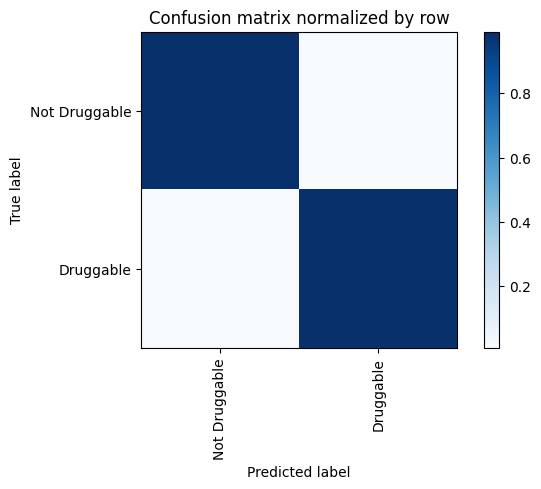

Overall accuracy: 0.989

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.986      0.992      0.989      0.519       1319|	 Druggable: 0.008,	
    Druggable       0.991      0.985      0.988      0.481       1223|	 Not Druggable: 0.015,	

----------------------------------------------------------------------------------------------------
  avg / total       0.989      0.989      0.989        1.0       2542|	      

Test Results...


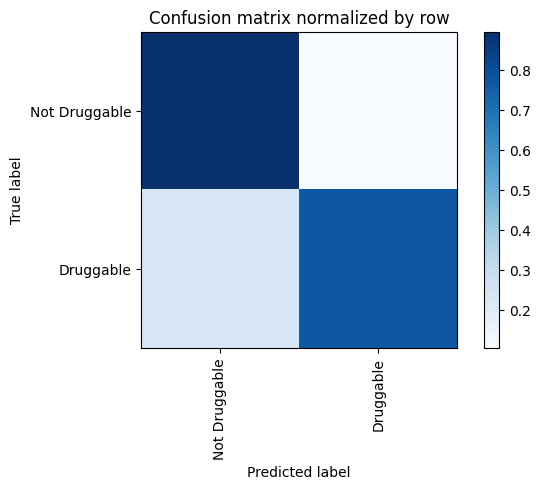

Overall accuracy: 0.835

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.806      0.895      0.848      0.514        237|	 Druggable: 0.105,	
    Druggable       0.874      0.772      0.820      0.486        224|	 Not Druggable: 0.228,	

----------------------------------------------------------------------------------------------------
  avg / total       0.839      0.835      0.834        1.0        461|	      

{'accuracy': 0.8351409978308026, 'precision': 0.8399105119637439, 'recall': 0.833418098251959, 'f1': 0.8339526066350711, 'sensitivity': 0.7723214285714286, 'specificity': 0.8945147679324894}



Model :- RandomForestClassifier(class_weight={0: 0.518, 1: 0.482}), DataType :- DPC_APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP
Train Results...


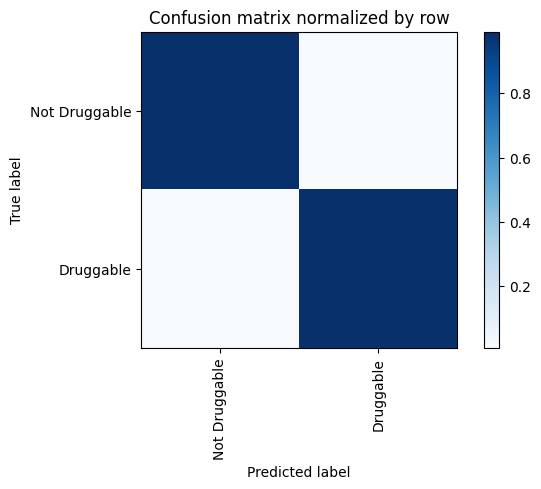

Overall accuracy: 0.989

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.986      0.992      0.989      0.519       1319|	 Druggable: 0.008,	
    Druggable       0.991      0.985      0.988      0.481       1223|	 Not Druggable: 0.015,	

----------------------------------------------------------------------------------------------------
  avg / total       0.989      0.989      0.989        1.0       2542|	      

Test Results...


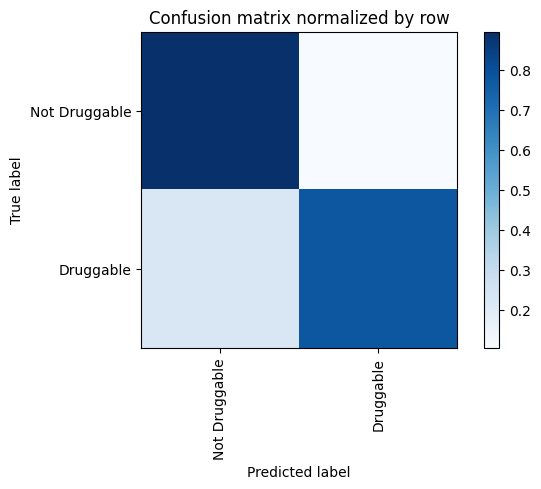

Overall accuracy: 0.837

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.809      0.895      0.850      0.514        237|	 Druggable: 0.105,	
    Druggable       0.874      0.777      0.823      0.486        224|	 Not Druggable: 0.223,	

----------------------------------------------------------------------------------------------------
  avg / total       0.841      0.837      0.837        1.0        461|	      

{'accuracy': 0.8373101952277657, 'precision': 0.8417660823199969, 'recall': 0.8356502411091018, 'f1': 0.836197217129294, 'sensitivity': 0.7767857142857143, 'specificity': 0.8945147679324894}



Model :- RandomForestClassifier(class_weight={0: 0.518, 1: 0.482}), DataType :- APAAC_RSacid_RSpolar_RSsecond_RScharge_RSDHP
Train Results...


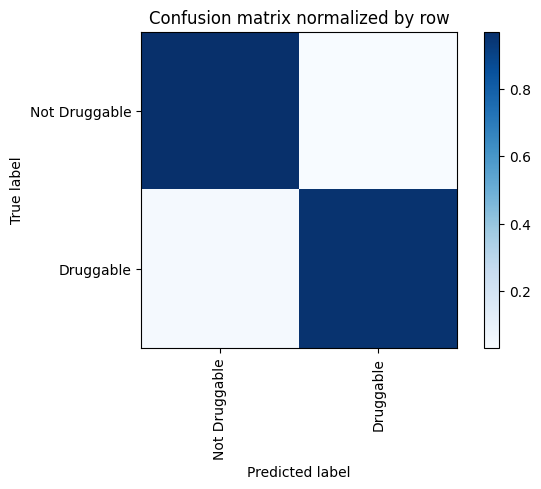

Overall accuracy: 0.961

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.958      0.968      0.963      0.519       1319|	 Druggable: 0.032,	
    Druggable       0.965      0.954      0.960      0.481       1223|	 Not Druggable: 0.046,	

----------------------------------------------------------------------------------------------------
  avg / total       0.961      0.961      0.961        1.0       2542|	      

Test Results...


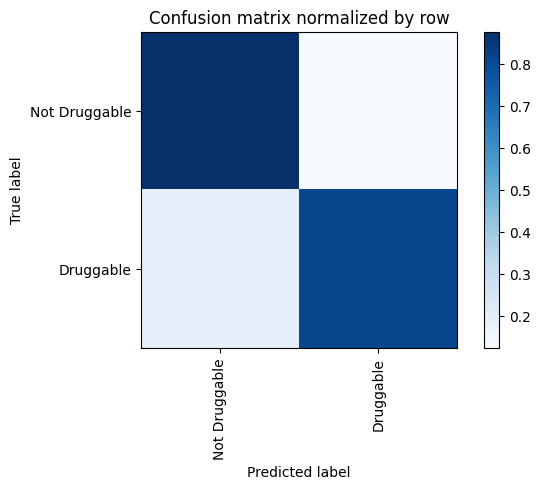

Overall accuracy: 0.844

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.829      0.878      0.852      0.514        237|	 Druggable: 0.122,	
    Druggable       0.862      0.808      0.834      0.486        224|	 Not Druggable: 0.192,	

----------------------------------------------------------------------------------------------------
  avg / total       0.845      0.844      0.844        1.0        461|	      

{'accuracy': 0.8438177874186551, 'precision': 0.8452950104344528, 'recall': 0.8428364225437011, 'f1': 0.8432801994409609, 'sensitivity': 0.8080357142857143, 'specificity': 0.8776371308016878}



Model :- RandomForestClassifier(class_weight={0: 0.518, 1: 0.482}), DataType :- RSacid_RSpolar_RSsecond_RScharge
Train Results...


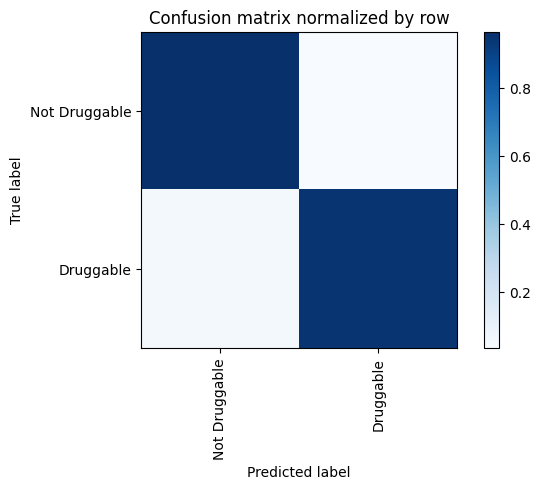

Overall accuracy: 0.959

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.954      0.967      0.960      0.519       1319|	 Druggable: 0.033,	
    Druggable       0.964      0.950      0.957      0.481       1223|	 Not Druggable: 0.050,	

----------------------------------------------------------------------------------------------------
  avg / total       0.959      0.959      0.959        1.0       2542|	      

Test Results...


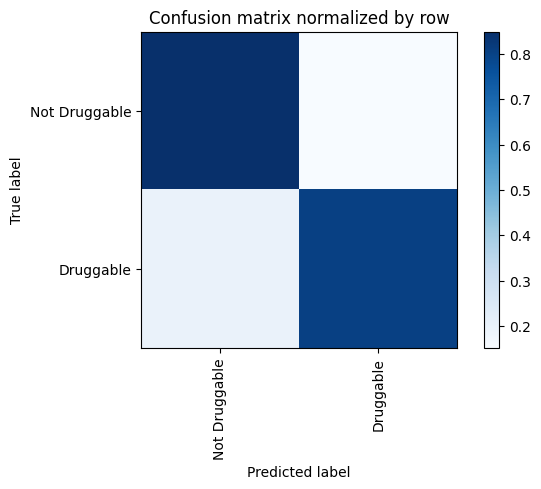

Overall accuracy: 0.826

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.820      0.848      0.834      0.514        237|	 Druggable: 0.152,	
    Druggable       0.833      0.804      0.818      0.486        224|	 Not Druggable: 0.196,	

----------------------------------------------------------------------------------------------------
  avg / total       0.827      0.826      0.826        1.0        461|	      

{'accuracy': 0.8264642082429501, 'precision': 0.8268707482993197, 'recall': 0.8258363471971066, 'f1': 0.8261033572236891, 'sensitivity': 0.8035714285714286, 'specificity': 0.8481012658227848}



Model :- RandomForestClassifier(class_weight={0: 0.518, 1: 0.482}), DataType :- DPC_RSDHP_RSacid_RSpolar_RSsecond_RScharge
Train Results...


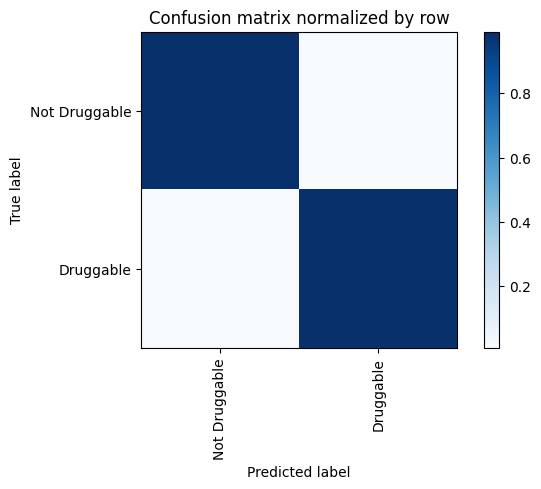

Overall accuracy: 0.989

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.987      0.992      0.989      0.519       1319|	 Druggable: 0.008,	
    Druggable       0.991      0.986      0.989      0.481       1223|	 Not Druggable: 0.014,	

----------------------------------------------------------------------------------------------------
  avg / total       0.989      0.989      0.989        1.0       2542|	      

Test Results...


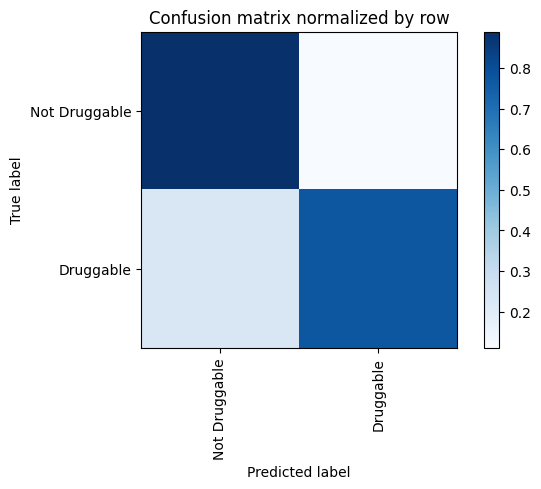

Overall accuracy: 0.833

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.805      0.890      0.846      0.514        237|	 Druggable: 0.110,	
    Druggable       0.869      0.772      0.818      0.486        224|	 Not Druggable: 0.228,	

----------------------------------------------------------------------------------------------------
  avg / total       0.836      0.833      0.832        1.0        461|	      

{'accuracy': 0.8329718004338394, 'precision': 0.8373451225593617, 'recall': 0.8313083936106088, 'f1': 0.8318291429194086, 'sensitivity': 0.7723214285714286, 'specificity': 0.890295358649789}



Model :- RandomForestClassifier(class_weight={0: 0.518, 1: 0.482}), DataType :- RSacid_RSpolar_RSsecond
Train Results...


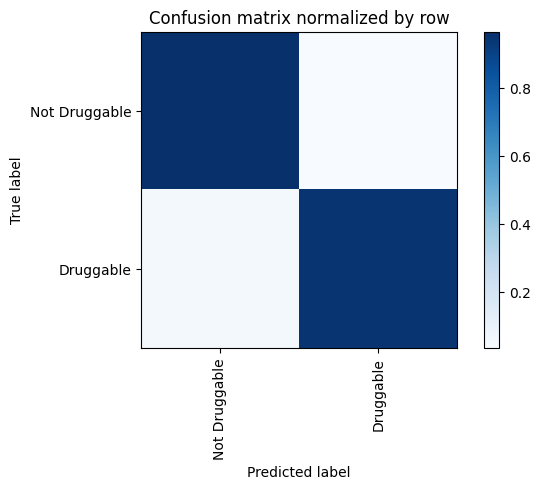

Overall accuracy: 0.956

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.951      0.964      0.958      0.519       1319|	 Druggable: 0.036,	
    Druggable       0.961      0.947      0.954      0.481       1223|	 Not Druggable: 0.053,	

----------------------------------------------------------------------------------------------------
  avg / total       0.956      0.956      0.956        1.0       2542|	      

Test Results...


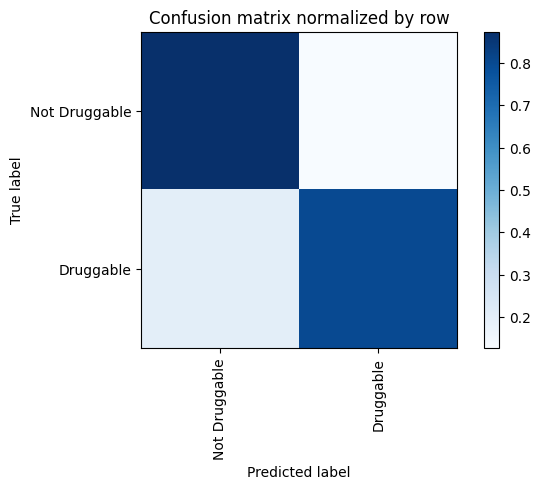

Overall accuracy: 0.837

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.821      0.873      0.847      0.514        237|	 Druggable: 0.127,	
    Druggable       0.856      0.799      0.827      0.486        224|	 Not Druggable: 0.201,	

----------------------------------------------------------------------------------------------------
  avg / total       0.838      0.837      0.837        1.0        461|	      

{'accuracy': 0.8373101952277657, 'precision': 0.8389439507860561, 'recall': 0.8362624321880652, 'f1': 0.8367078026041741, 'sensitivity': 0.7991071428571429, 'specificity': 0.8734177215189873}



Model :- RandomForestClassifier(class_weight={0: 0.518, 1: 0.482}), DataType :- RSacid_RSpolar
Train Results...


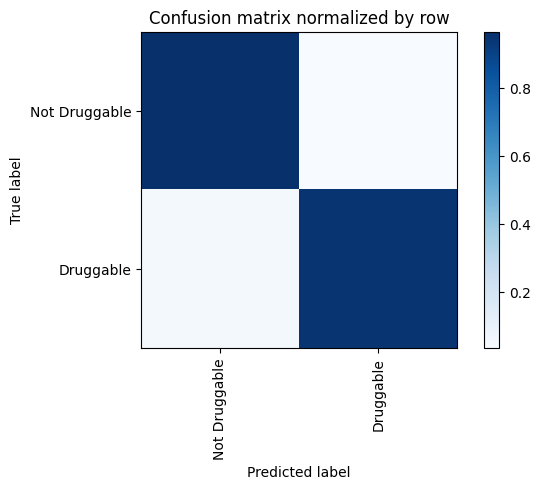

Overall accuracy: 0.956

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.951      0.965      0.958      0.519       1319|	 Druggable: 0.035,	
    Druggable       0.962      0.946      0.954      0.481       1223|	 Not Druggable: 0.054,	

----------------------------------------------------------------------------------------------------
  avg / total       0.956      0.956      0.956        1.0       2542|	      

Test Results...


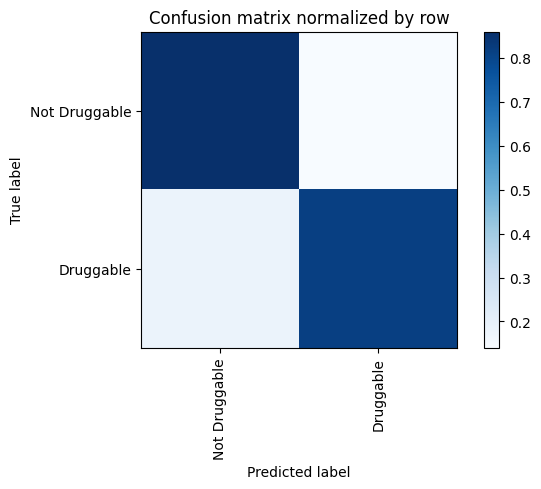

Overall accuracy: 0.839

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.833      0.861      0.846      0.514        237|	 Druggable: 0.139,	
    Druggable       0.847      0.817      0.832      0.486        224|	 Not Druggable: 0.183,	

----------------------------------------------------------------------------------------------------
  avg / total       0.840      0.839      0.839        1.0        461|	      

{'accuracy': 0.8394793926247288, 'precision': 0.8399376417233559, 'recall': 0.8388618896925859, 'f1': 0.8391456054319125, 'sensitivity': 0.8169642857142857, 'specificity': 0.8607594936708861}





In [19]:
for feat_comb in feat_combinations:
    
    ensemble = RandomForestClassifier(class_weight={1:0.482,0:0.518})
    ensemble_str = "RandomForestClassifier"
    
    print(f"Model :- {ensemble}, DataType :- {feat_comb}")
    os.makedirs(os.path.join(config["ensemble_loc"],feat_comb,str(ensemble_str)),exist_ok=True)
    model_dir = os.path.join(config["ensemble_loc"],feat_comb,str(ensemble_str))
    
    print("Train Results...") 
    
    probabilities = []
    for feat_type in feat_comb.split("_"):
        pipeline = joblib.load(os.path.join(config["model_save_loc"],feat_type,sel_model[feat_type],"pipeline.sav"))
        clf = joblib.load(os.path.join(config["model_save_loc"],feat_type,sel_model[feat_type],"model_save.sav"))
        
        X = X_train[feat_type]
        X = pipeline.transform(X)
        
        y_pred = clf.decision_function(X).reshape(-1,1)
        probabilities.append(y_pred)
     
    probabilities = np.concatenate(probabilities,axis=-1)
    y_pred = cross_val_predict(ensemble, probabilities, train_data.targets, cv=5)
    
    result_values = action_evaluator(y_pred,train_data.targets,class_names=["Not Druggable","Druggable"],save_outputs=model_dir)
    
    ensemble.fit(probabilities, train_data.targets)
    
    print("Test Results...") 
    
    probabilities = []
    for feat_type in feat_comb.split("_"):
        pipeline = joblib.load(os.path.join(config["model_save_loc"],feat_type,sel_model[feat_type],"pipeline.sav"))
        clf = joblib.load(os.path.join(config["model_save_loc"],feat_type,sel_model[feat_type],"model_save.sav"))
        
        X = X_test[feat_type]
        X = pipeline.transform(X)
        
        y_pred = clf.decision_function(X).reshape(-1,1)
        probabilities.append(y_pred)
        
    probabilities = np.concatenate(probabilities,axis=-1)
    
    y_pred = ensemble.predict(probabilities)
    result_values = action_evaluator(y_pred,test_data.targets,class_names=["Not Druggable","Druggable"],save_outputs=model_dir)
    
    joblib.dump(ensemble,os.path.join(model_dir,"model_save.sav"))
    print(result_values)
    print("\n\n")